# 내용 정리
- 밑에 출력문이 길어서 결과에 대한 정리를 위에 적는게 좋을 것 같다.  
<br>  

## 모델 ```VGG16```은 동일, train data의 양 차이
- 처음에 train data를 Augmentation하지 않았을 때는 정확도가 ```0.8556```가 나왔다.
- 점수를 더 올려보기 위해서 Augmentation을 시도해보았고 그 결과 ```0.8910```이 나온 것을 확인 할 수 있었다.
- 모델이 학습할 때, 데이터의 양이 적당하게 많아야지 좀 더 학습이 잘 되는 것을 알 수 있었다.
- 무엇보다 마지막에 인터넷에서 따로 사진을 가져와서 확인해보았을 때, 제대로 분류를 해내었다.
 
<br>  


## 그렇다면 다른 모델일 경우에는? (```ResNet50```, ```MobileNetV2```, ```InceptionV3```)
- ```VGG16```모델 뿐만 아니라 다른 모델들도 학습을 시켜보았다.
- 데이터는 위에서 확인한 결과로, Augmentation을 한 데이터로 사용하였고 복잡한 모델일 경우에 파라미터 수가 데이터의 양에 비해서 지나치게 많다면 **Overfitting**이 일어날 것으로 생각하고 다음과 같은 callback인자를 추가하였다.
    1. EarlyStopping
        - ```val_loss```가 줄어들다가 오를 때, 3번까지 더 학습을 해보고 계속 오른다면 학습을 중지하도록 하였다.
    2. LearningRateScheduler
        - epoch가 5번 이하라면 학습률(Learning Rate)을 0.0001로 그대로 학습을 진행한다.
        - 5번 이상이라면 5번 이후로 학습을 진행하면서 학습률을 조금씩 낮춰가면서 학습을 진행한다.  
         
<br>  

        
### 의문점
- ```ResNet50```, ```MobileNetV2```, ```InceptionV3```의 모델들의 공통점은 epochs가 10번을 넘기지 못하고 ```val_loss```가 증가하였고 정확도도 만족스럽지 않게 나왔다.
- 하지만 ```InceptionV3```의 경우 ```evaluate```를 했을 때, 90점의 높은 점수가 나왔다.
- 3개의 모델에 대해서 인터넷에서 따로 가져온 민들레, 데이지, 장미에 대해서 결과를 출력해본 결과 **하나의 class로 예측**을 하는 결과가 나왔다.
- 다음과 같이 생각을 해보았다.
    1. 학습을 도중에 멈추더라도 이미 모델은 Overfitting이 일어났다.
        - ```patience```가 3인데 이 수를 2로 낮춘다면?
    2. Train Data가 하나의 클래스로 편향되어 있다면?
        - 하지만 ```VGG``` 모델의 경우, 같은 데이터셋으로 학습하고 같은 사진으로 결과를 확인해보면 제대로 결과가 나왔다.
    3. 정규화 및 다른 스킬을 사용해서 학습을 더 진행해본다면?
        - 각각의 ```base model```에는 이미 ```BatchNormalization``` 층이 있었다.
        - 확인했던 모델은 ```ResNet```이었다. 다른 모델들도 한번 확인해 보도록 한다.
    4. train에 비해서 validation의 값이 터무니 없이 작은가?
        - TensorFlow공식 문서에서 Augmentation은 Train Data에 한해서 수행한다고 했다.
        - 아닌가..?
    5. 모델에 비해서 데이터가 역시 작은가?  
    
<br>  

        
## 전체적인 코드의 구조
- 이 노트북 파일은 jupyter notebook의 확장 프로그램에서 ```Table of Contents``` 기능을 사용하면 더 편하게 볼 수 있다.
- 다양한 모델을 만들고, 학습하고, 결과를 확인하기 위해 다음과 같은 함수들을 만들었다.
    1. ```init_model(model_name, input_size)```
        - 입력 : 구조를 가져올 모델명과 이미지의 사이즈를 입력받는다. (사이즈는 전처리 할 때 사용한 사이즈를 사용했다.)
        - 출력 : 모델을 반환한다.
    2. ```compile_fit(model, input_data, valid_data=False, lr=0.0001, epochs=20, callback=False)```
        - 입력 : 위에서 반환 받은 모델, test data, validation data, 학습률, epoch 수, 마지막으로 ```callback```을 True할 경우, 위에서 설명한 두개의 callback을 사용하게 된다.
        - 출력 : fin을 통해서 반환받는 것을 그대로 반환하였다.
    3. ```result_plot(history)```
        - 입력 : 위에서 학습시킨 후 반환 받는 내용을 입력으로 받게 된다.
        - 출력 : train, validation에 대한 loss, acc를 그래프로 그려준다.
    4. ```predict_plot(test_dataset)```
        - 32개의 test 데이터로 예측을 하고, 사진과 예측 결과를 보여준다.
    5. ```show_and_predict_image(dirpath, img_size)```
        - ```dirpath```에 저장한 이미지들을 예측하고 각 label에 대한 예측 퍼센트를 출력해준다.
    

# 코드

## 라이브러리 import

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from glob import glob
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(940415)

## 데이터 가져오기

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)

## 전처리

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 160

In [4]:
def resize(image, label) :
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
def augment(image, label) :
    image, label = resize(image, label)
    
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.clip_by_value(image, -1, 1)
    return image, label

### resize, rescale

In [6]:
train = (
    raw_train
    .shuffle(1000)
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [7]:
val = (
    raw_validation
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [8]:
test = (
    raw_test
    .map(resize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

### resize, rescale, augmentation

In [9]:
train_aug = (
    raw_train
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

##  모델 생성, 학습

### init_model 함수
- 입력 인자
    1. model_name (VGG16, VGG19, ResNet50, ResNet50V2, MobileNetV2, InceptionV3)
    2. input_img size
- 출력 인자
    1. model

In [10]:
def init_model(model_name, input_size):
    input_shape = (input_size, input_size, 3)

    if model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
    elif model_name == "VGG19":
        base_model = tf.keras.applications.VGG19(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
    elif model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
    elif model_name == "ResNet50V2":
        base_model = tf.keras.applications.ResNet50V2(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet') 
    elif model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet') 
    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
    else :
        print("please choose one : VGG16, VGG19, ResNet50, ResNet50V2, MobileNetV2, InceptionV3")
        return False
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_layer = tf.keras.layers.Dense(512, activation='relu')
    prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      dense_layer,
      prediction_layer
    ])
    
    return model

### compile_fit 함수
- 입력인자
    1. model
    2. input_data
    3. valid_data (Default = False)
    4. lr (Default = 0.0001)
    5. epochs (Default = 20)
    6. callback (Default = False)
        - ```EarlyStopping``` 과 ```LearningRateScheduler``` 사용 여부
- 출력인자
    1. history

In [11]:
def compile_fit(model, input_data, valid_data=False, lr=0.0001, epochs=20, callback=False):
    # callback : learning rate shceduler, early stop
    print("Compiling...\n")
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
        
    
    print("Fitting...\n")
    if not valid_data :
        history = model.fit(input_data,
                            epochs=epochs
                           )
    else :
        if callback :
            
            # early stop, LearningRateScheduler 정의
            es = EarlyStopping(monitor='val_loss', patience=3)
            
            def scheduler(epochs):
                if epochs < 5 :
                    return 0.0001
                else :
                    return 0.0001 * tf.math.exp(0.1 * (10-epochs))
            lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
            
            # 학습
            history = model.fit(input_data,
                               epochs=epochs,
                               validation_data=valid_data,
                               callbacks=[es, lrs]
                               )
            
        else :
            history = model.fit(input_data,
                                epochs=epochs,
                                validation_data=valid_data
                               )

    return history

### result_plot 함수

In [12]:
def result_plot(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    # range함수?
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### 모델 학습 및 결과

####  VGG16, ```train``` 데이터셋 사용

In [13]:
model = init_model("VGG16", IMG_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 14,979,909
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = compile_fit(model, train, valid_data=val)

Compiling...

Fitting...

Epoch 1/20
92/92 [==============================] - 84s 913ms/step - loss: 1.4643 - accuracy: 0.3655 - val_loss: 1.1194 - val_accuracy: 0.5014
Epoch 2/20
92/92 [==============================] - 20s 219ms/step - loss: 0.9082 - accuracy: 0.6594 - val_loss: 0.8922 - val_accuracy: 0.7193
Epoch 3/20
92/92 [==============================] - 20s 220ms/step - loss: 0.6133 - accuracy: 0.7715 - val_loss: 0.5596 - val_accuracy: 0.7738
Epoch 4/20
92/92 [==============================] - 20s 222ms/step - loss: 0.5672 - accuracy: 0.8076 - val_loss: 0.5479 - val_accuracy: 0.7847
Epoch 5/20
92/92 [==============================] - 20s 222ms/step - loss: 0.4247 - accuracy: 0.8460 - val_loss: 0.5813 - val_accuracy: 0.7657
Epoch 6/20
92/92 [==============================] - 20s 221ms/step - loss: 0.4172 - accuracy: 0.8675 - val_loss: 0.3291 - val_accuracy: 0.9210
Epoch 7/20
92/92 [==============================] - 20s 222ms/step - loss: 0.3262 - accuracy: 0.8859 - val_loss: 2.8

In [15]:
loss0, accuracy0 = model.evaluate(test, batch_size=BATCH_SIZE)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 1s 69ms/step - loss: 0.4233 - accuracy: 0.8556
initial loss: 0.42
initial accuracy: 0.86


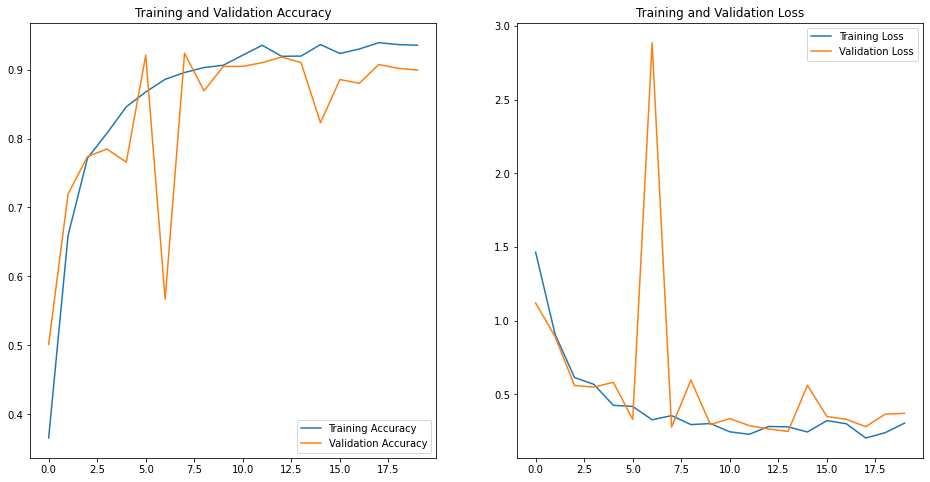

In [16]:
result_plot(history)

#### VGG16, ```train_aug```사용

In [17]:
model = init_model("VGG16", input_size=IMG_SIZE)

In [18]:
history = compile_fit(model, train_aug, val)

Compiling...

Fitting...

Epoch 1/20
92/92 [==============================] - 21s 229ms/step - loss: 1.4420 - accuracy: 0.3774 - val_loss: 0.8115 - val_accuracy: 0.6512
Epoch 2/20
92/92 [==============================] - 21s 224ms/step - loss: 0.8471 - accuracy: 0.6829 - val_loss: 0.5004 - val_accuracy: 0.8256
Epoch 3/20
92/92 [==============================] - 21s 224ms/step - loss: 0.6276 - accuracy: 0.7701 - val_loss: 0.6066 - val_accuracy: 0.7738
Epoch 4/20
92/92 [==============================] - 21s 223ms/step - loss: 0.5077 - accuracy: 0.8188 - val_loss: 0.5468 - val_accuracy: 0.7929
Epoch 5/20
92/92 [==============================] - 20s 222ms/step - loss: 0.4421 - accuracy: 0.8518 - val_loss: 0.3297 - val_accuracy: 0.8747
Epoch 6/20
92/92 [==============================] - 21s 224ms/step - loss: 0.4613 - accuracy: 0.8508 - val_loss: 0.3139 - val_accuracy: 0.8937
Epoch 7/20
92/92 [==============================] - 21s 224ms/step - loss: 0.3420 - accuracy: 0.8757 - val_loss: 0.5

In [19]:
loss0, accuracy0 = model.evaluate(test, batch_size=BATCH_SIZE)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 1s 67ms/step - loss: 0.5133 - accuracy: 0.8910
initial loss: 0.51
initial accuracy: 0.89


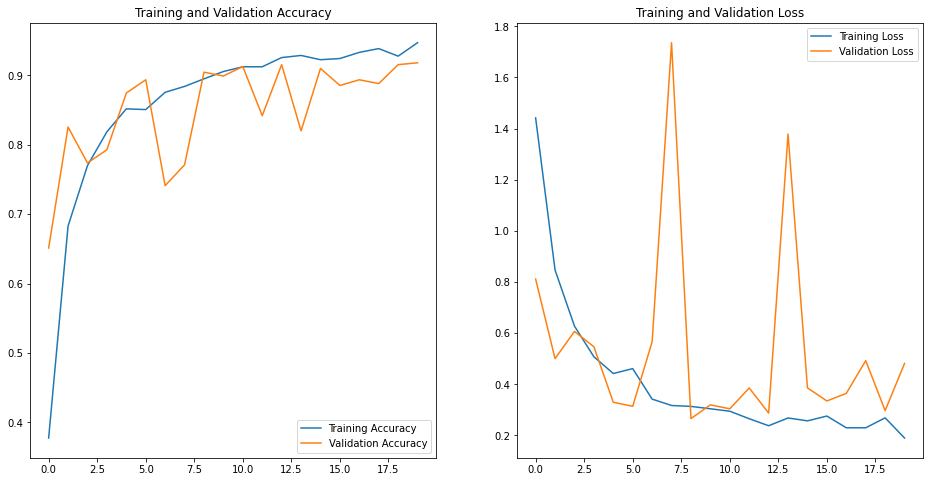

In [20]:
result_plot(history)

## 결과 시각화 (VGG16, Augmentation 데이터)

### predict_plot 함수

In [21]:
def predict_plot(test_dataset) :
    for image_batch, label_batch in test.take(1):
        images = image_batch
        labels = label_batch
        predictions = model.predict(image_batch)
        pass

    predictions = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(20, 12))

    for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
        plt.subplot(4, 8, idx+1)
        image = (image + 1) / 2
        plt.imshow(image)
        correct = label == prediction
        title = f'real: {label} / pred :{prediction}\n {correct}!'
        if not correct:
            plt.title(title, fontdict={'color': 'red'})
        else:
            plt.title(title, fontdict={'color': 'blue'})
        plt.axis('off')

### show_and_predict_image 함수

In [22]:
def show_and_predict_image(dirpath, img_size):
    
    file_paths = glob(dirpath + '*')

    for filepath in tqdm(file_paths):
        print("\nprocessing : {}".format(filepath))
        image = load_img(filepath, target_size=(img_size, img_size))
        plt.imshow(image)
        plt.axis('off')
        image = img_to_array(image).reshape(1, img_size, img_size, 3)
        prediction = model.predict(image)[0]
        label0_percentage = round(prediction[0] * 100)
        label1_percentage = round(prediction[1] * 100)
        label2_percentage = round(prediction[2] * 100)
        label3_percentage = round(prediction[3] * 100)
        label4_percentage = round(prediction[4] * 100)
        plt.show()
        print(f"This image seems {label0_percentage}% dandelion, and {label1_percentage}% daisy, and {label2_percentage}% tulips, and {label3_percentage}% sunflowers, and {label4_percentage}% roses")
        print("\n"+("-"*60))

### 결과 시각화

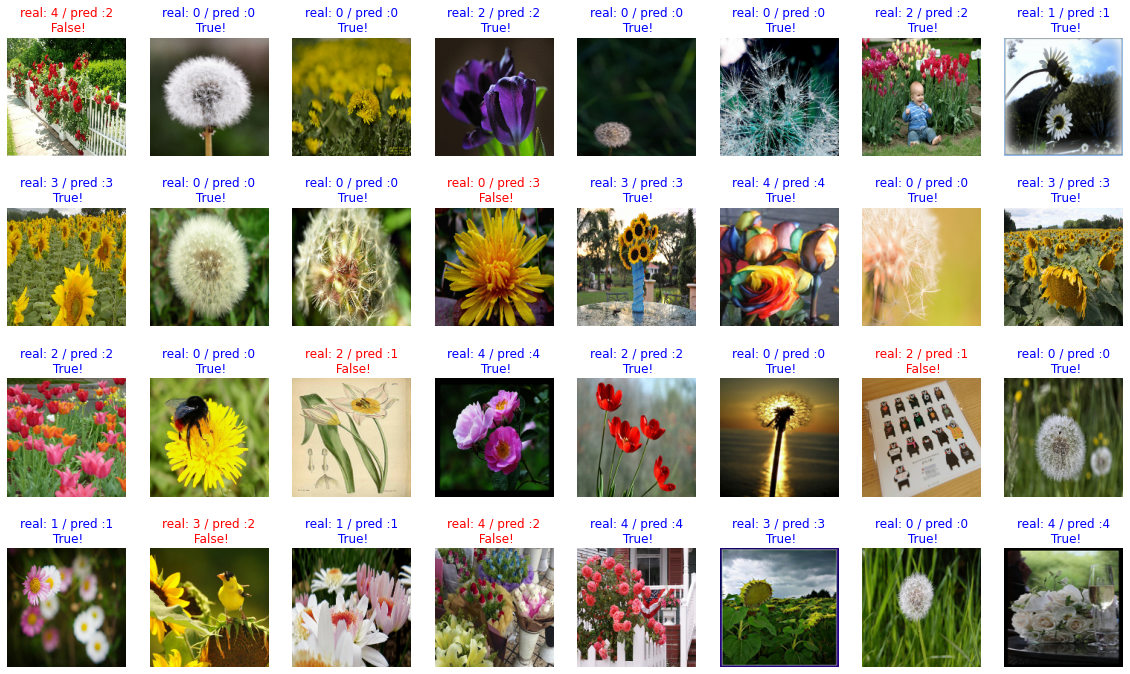

In [23]:
predict_plot(test)


processing : ./test_img/min.jpg


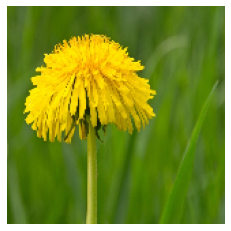

This image seems 100.0% dandelion, and 0.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 0.0% roses

------------------------------------------------------------

processing : ./test_img/rose.jpeg


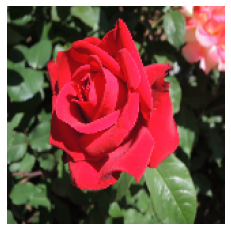

This image seems 0.0% dandelion, and 0.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 100.0% roses

------------------------------------------------------------

processing : ./test_img/daisy.jpeg


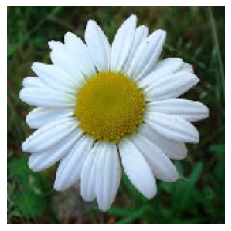

This image seems 0.0% dandelion, and 100.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 0.0% roses

------------------------------------------------------------



In [24]:
show_and_predict_image('./test_img/', img_size=IMG_SIZE)

# 중간 정리
## VGG16 모델로 학습
- 처음 학습은 데이터셋을 그대로 사용했고, 그 다음엔 데이터의 양을 늘려서 확인해보았다.
- 그 결과 정확도는 ```0.8338```에서 ```0.8883```로 올랐다.  

## 다른 모델은 어떨까?
1. MobilNetV2
2. ResNet50V2
3. InceptionV3<br>

 - 같은 방식으로 기존의 데이터, augmentation한 데이터로 비교를 해본다.



### MobilNetV2

In [25]:
model = init_model('MobileNetV2', IMG_SIZE)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 2,882,309
Non-trainable params: 34,112
_________________________________________________________________


Compiling...

Fitting...

Epoch 1/20
92/92 [==============================] - 120s 1s/step - loss: 0.5003 - accuracy: 0.8208 - val_loss: 0.5814 - val_accuracy: 0.8147 - lr: 1.0000e-04
Epoch 2/20
92/92 [==============================] - 10s 105ms/step - loss: 0.1841 - accuracy: 0.9380 - val_loss: 0.4628 - val_accuracy: 0.8529 - lr: 1.0000e-04
Epoch 3/20
92/92 [==============================] - 10s 105ms/step - loss: 0.1117 - accuracy: 0.9642 - val_loss: 0.6483 - val_accuracy: 0.8365 - lr: 1.0000e-04
Epoch 4/20
92/92 [==============================] - 10s 106ms/step - loss: 0.0576 - accuracy: 0.9816 - val_loss: 0.5144 - val_accuracy: 0.8692 - lr: 1.0000e-04
Epoch 5/20
92/92 [==============================] - 10s 107ms/step - loss: 0.0374 - accuracy: 0.9877 - val_loss: 0.7979 - val_accuracy: 0.8392 - lr: 1.0000e-04


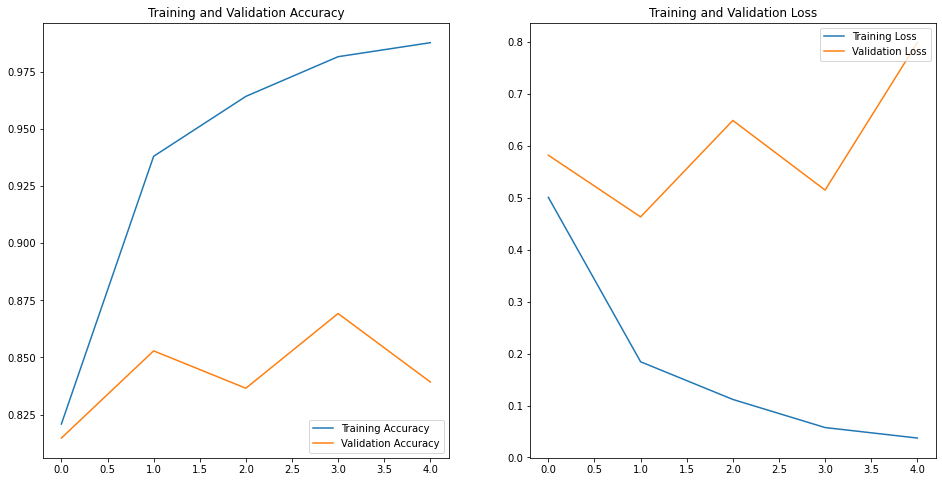

In [26]:
history = compile_fit(model, train_aug, valid_data=val, callback=True)
result_plot(history)

In [27]:
model.evaluate(test)

12/12 [==============================] - 0s 15ms/step - loss: 0.8474 - accuracy: 0.8120


[0.8474058508872986, 0.8119891285896301]


processing : ./test_img/min.jpg


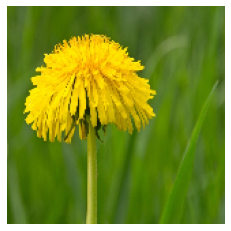

This image seems 0.0% dandelion, and 0.0% daisy, and 99.0% tulips, and 1.0% sunflowers, and 0.0% roses

------------------------------------------------------------

processing : ./test_img/rose.jpeg


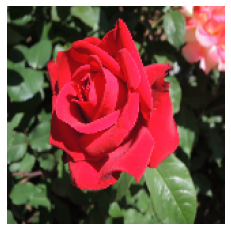

This image seems 0.0% dandelion, and 0.0% daisy, and 98.0% tulips, and 2.0% sunflowers, and 0.0% roses

------------------------------------------------------------

processing : ./test_img/daisy.jpeg


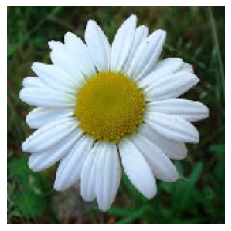

This image seems 0.0% dandelion, and 0.0% daisy, and 96.0% tulips, and 3.0% sunflowers, and 0.0% roses

------------------------------------------------------------



In [28]:
show_and_predict_image('./test_img/', img_size=IMG_SIZE)

### ResNet50

In [29]:
model = init_model('ResNet50', IMG_SIZE)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 24,586,245
Non-trainable params: 53,120
_________________________________________________________________


Compiling...

Fitting...

Epoch 1/10
92/92 [==============================] - 129s 1s/step - loss: 0.5035 - accuracy: 0.8287 - val_loss: 4.8457 - val_accuracy: 0.1689
Epoch 2/10
92/92 [==============================] - 16s 179ms/step - loss: 0.1452 - accuracy: 0.9527 - val_loss: 2.2246 - val_accuracy: 0.2425
Epoch 3/10
92/92 [==============================] - 16s 178ms/step - loss: 0.0729 - accuracy: 0.9762 - val_loss: 2.1969 - val_accuracy: 0.3079
Epoch 4/10
92/92 [==============================] - 17s 180ms/step - loss: 0.0643 - accuracy: 0.9837 - val_loss: 4.3728 - val_accuracy: 0.2970
Epoch 5/10
92/92 [==============================] - 17s 180ms/step - loss: 0.0547 - accuracy: 0.9843 - val_loss: 16.6837 - val_accuracy: 0.4223
Epoch 6/10
92/92 [==============================] - 16s 178ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 12.6737 - val_accuracy: 0.5395
Epoch 7/10
92/92 [==============================] - 17s 181ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 43.

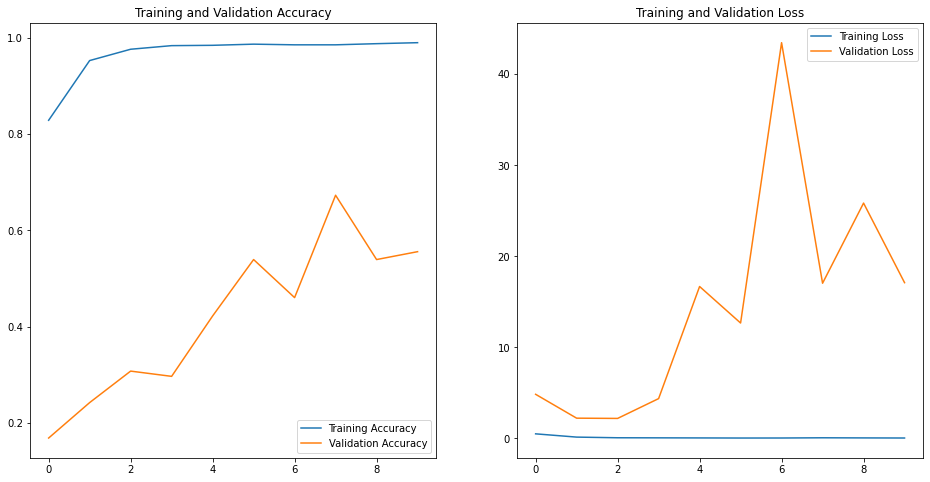

In [30]:
history = compile_fit(model, train_aug, valid_data=val, callback=True)
result_plot(history)

In [31]:
model.evaluate(test)

12/12 [==============================] - 0s 41ms/step - loss: 11.9829 - accuracy: 0.6676


[11.982872009277344, 0.667574942111969]


processing : ./test_img/min.jpg


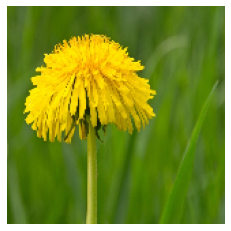

This image seems 0.0% dandelion, and 0.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 100.0% roses

------------------------------------------------------------

processing : ./test_img/rose.jpeg


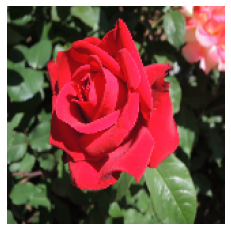

This image seems 0.0% dandelion, and 0.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 100.0% roses

------------------------------------------------------------

processing : ./test_img/daisy.jpeg


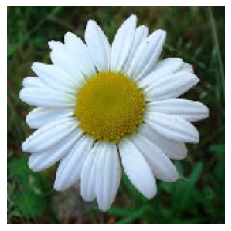

This image seems 0.0% dandelion, and 0.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 100.0% roses

------------------------------------------------------------



In [32]:
show_and_predict_image('./test_img/', img_size=IMG_SIZE)

### InceptionV3

In [33]:
model = init_model('InceptionV3', IMG_SIZE)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 22,854,437
Trainable params: 22,820,005
Non-trainable params: 34,432
_________________________________________________________________


Compiling...

Fitting...

Epoch 1/20
92/92 [==============================] - 296s 3s/step - loss: 0.6763 - accuracy: 0.7612 - val_loss: 0.5563 - val_accuracy: 0.8638 - lr: 1.0000e-04
Epoch 2/20
92/92 [==============================] - 12s 135ms/step - loss: 0.2795 - accuracy: 0.8961 - val_loss: 0.8304 - val_accuracy: 0.8610 - lr: 1.0000e-04
Epoch 3/20
92/92 [==============================] - 12s 130ms/step - loss: 0.1329 - accuracy: 0.9530 - val_loss: 0.6377 - val_accuracy: 0.8747 - lr: 1.0000e-04
Epoch 4/20
92/92 [==============================] - 12s 131ms/step - loss: 0.1007 - accuracy: 0.9646 - val_loss: 0.7570 - val_accuracy: 0.9019 - lr: 1.0000e-04


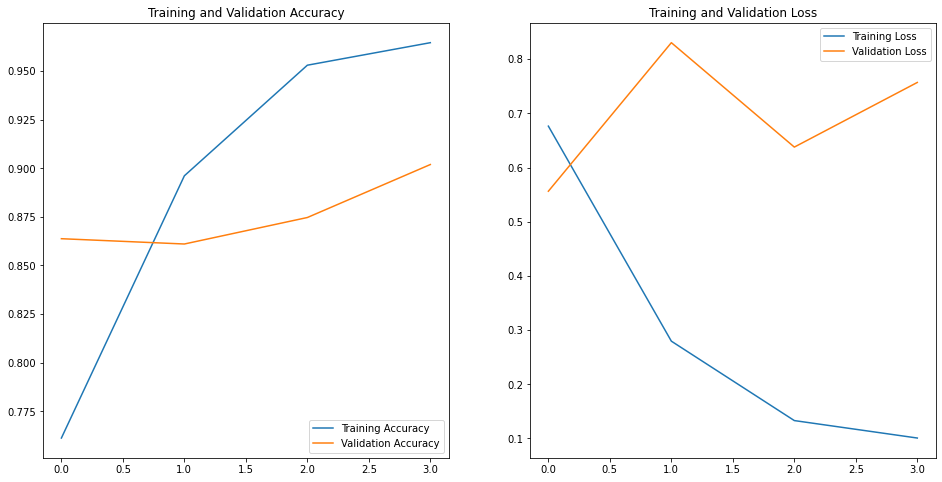

In [34]:
history = compile_fit(model, train_aug, valid_data=val, callback=True)
result_plot(history)

In [35]:
model.evaluate(test)

12/12 [==============================] - 0s 31ms/step - loss: 0.5040 - accuracy: 0.9019


[0.5039563179016113, 0.9019073843955994]


processing : ./test_img/min.jpg


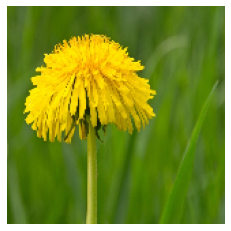

This image seems 0.0% dandelion, and 100.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 0.0% roses

------------------------------------------------------------

processing : ./test_img/rose.jpeg


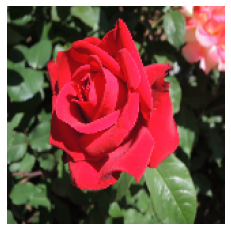

This image seems 0.0% dandelion, and 100.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 0.0% roses

------------------------------------------------------------

processing : ./test_img/daisy.jpeg


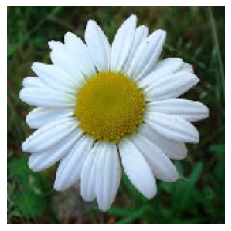

This image seems 0.0% dandelion, and 100.0% daisy, and 0.0% tulips, and 0.0% sunflowers, and 0.0% roses

------------------------------------------------------------



In [36]:
show_and_predict_image('./test_img/', img_size=IMG_SIZE)